<center>
In God We Trust
</center>

# CE417: Artificial Intelligence

Dr. Mahdiyeh Soleymani Baghshah, Associate Professor

Computer Engineering Department,
Sharif University of Technology,
Tehran, Tehran, Iran


# MNIST Autoencoder (20 Points)

Corresponding TA: Aryan Ahadinia

In this problem, we want to train an autoencoder. Autoencoder is a type of neural network which is used for unsupervised tasks. Figure below is showing a simple autoencoder.

<center>
<img src="./assets/autoencoder.png" style="width: 50%">
</center>

We want to train a neural network which get a noisy image as input and denoise it in the output. We focus on MNIST dataset. MNIST is a dataset containing 60000 images of hand-written digits. We artificially add a random noise to images and then we train our network to get the noisy image as input and give the cleared image in the output.

<center>
<img src="./assets/desc.png" style="width: 50%">
</center>


If you have an nVidia CUDA-compatible GPU, you can proceed to install CUDA and a CUDA-compatible pytorch versions. You can also use Google Colaboratory or Kaggle.
 

In [ ]:
%pip install numpy
%pip install tqdm
%pip install matplotlib
%pip install torch torchvision torchaudio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn

from tqdm import tqdm


In cell below, we load our data.

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

mnist_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Now we want to wrap our dataset in torch datasets. Each item in our dataset must contain three entities, the noisy image, the original image and the label. Apply a noise on the original image regarding the noise factor.

Complete cell below. (3 Points)


In [ ]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, noise_factor=0.5):
        self.dataset = dataset
        self.noise_factor = noise_factor
        

    def __getitem__(self, index):
        raw_data = self.dataset[index]
        noisy_data = raw_data[0] + self.noise_factor * torch.randn_like(raw_data[0])
        noisy_data = torch.clip(noisy_data, 0., 1.)
        return noisy_data, raw_data[1]

    def __len__(self):
        return len(self.dataset)


In [ ]:
noisy_mnist_train = NoisyDataset(mnist_train, 0.6)
noisy_mnist_test = NoisyDataset(mnist_test, 0.6)
mnist_train_loader = torch.utils.data.DataLoader(
    noisy_mnist_train, batch_size=60, shuffle=True
)
mnist_test_loader = torch.utils.data.DataLoader(
    noisy_mnist_test, batch_size=60, shuffle=True
)


Now, design a proper network architecture. Complete cell below. (6 Points)

In [69]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # First we encode the image by 4 layers
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9),
            torch.nn.ReLU(),
        )

        # Then we decode the image by reverse of 4 layers
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid(),
        )

        # We concatenate the encoder and decoder to make the network
        self.network = torch.nn.Sequential(self.encoder, self.decoder)
        

    def forward(self, img):
        forwarded = self.network(img)
        return forwarded
        


Now, train the network. We recommend MSE Loss and Adam Optimizer. (6 Points)

In [71]:
# Create the model
model = Net()

# Define the loss function
loss_func = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)

Now, plot the results like figure above. (5 Points)

First we train the model.

In [74]:
count_epoch = 5
losses = []
outputs = []
max_losses = []
for epoch in range(count_epoch):
    max_loss = 0
    for i, data in enumerate(tqdm(mnist_train_loader)):
        if epoch == 0:
          outputs.append([])
        img, _ = data
        img = img.view(-1, 28 * 28)
        # ===================forward=====================
        output = model(img)
        loss = loss_func(output, img)
        if max_loss < loss:
            max_loss = loss
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        losses.append(loss)
        outputs[i].append(output)
    max_losses.append(max_loss)


100%|██████████| 1000/1000 [00:22<00:00, 43.96it/s]


Visualization of training.

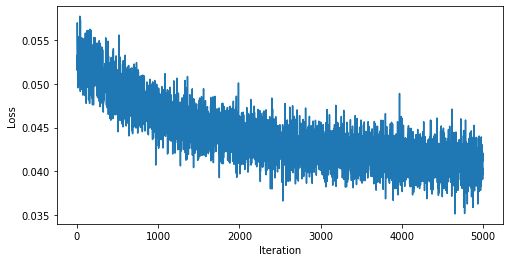

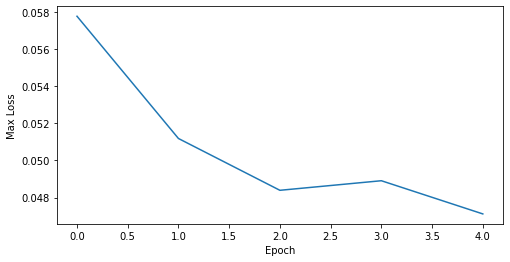

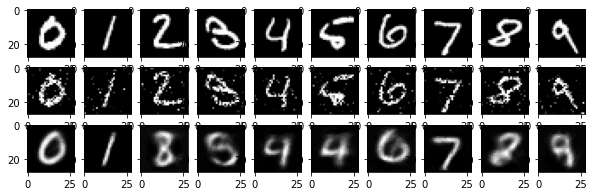

In [75]:
# Plotting loss of all iterations and max_loss of each epoch
plt.figure(figsize=(8, 4))
losses = np.array([loss.item() for loss in losses])
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(8, 4))
max_losses = np.array([loss.item() for loss in max_losses])
plt.plot(max_losses)
plt.xlabel("Epoch")
plt.ylabel("Max Loss")
plt.show()

# Testing the test set
plt.figure(figsize=(10, 3))
for digit in range(10):
    i = 0
    # Find the first image of digit
    while mnist_test[i][1] != digit:
        i += 1
    # Plot the image and its noisy version and the output of the autoencoder
    plt.subplot(3, 10, digit + 1)
    plt.imshow(mnist_test[i][0].reshape(28, 28), cmap="gray")
    plt.subplot(3, 10, digit + 1 + 10)
    plt.imshow(noisy_mnist_test[i][0].reshape(28, 28), cmap="gray")
    plt.subplot(3, 10, digit + 1 + 20)
    plt.imshow(model(noisy_mnist_test[i][0].reshape(-1, 28 * 28)).detach().numpy().reshape(28, 28), cmap="gray")
plt.show()   